# Código recurso para generar figuras que introducir luego en el documento del trabajo.

In [73]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix
import time
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
import sys
import random
import seaborn as sns

import sklearn
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim

np.set_printoptions(threshold=sys.maxsize)


In [74]:
plt.rcParams.update({
    'text.usetex': True,  # Usar LaTeX para el texto
    # 'text.usetex': False,  # NO Usar LaTeX para el texto
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

### Funciones de activación

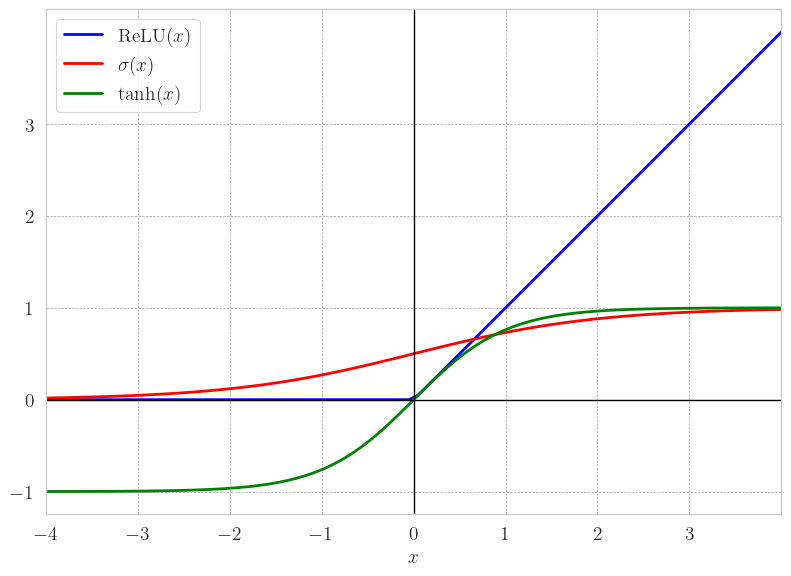

In [75]:
# Crear un rango de valores para x
x = np.linspace(-4, 4, 80)

# Definir la función ReLU
def relu(x):
    return np.maximum(0, x)

# definir la función sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# definir la función tangente hiperbólica
def tanh(x):
    return np.tanh(x)

# Calcular los valores de las funciones de activación
relu = relu(x)
sigmoid = sigmoid(x)
tanh = tanh(x)


# Configuración de la figura para publicación científica
plt.figure(figsize=(8, 6))

# Graficar las funciones de activación
plt.plot(x, relu, label=r'$\mathrm{ReLU}(x)$', color='blue', linewidth=2)
plt.plot(x, sigmoid, label=r'$\sigma(x)$', color='red', linewidth=2)
plt.plot(x, tanh, label=r'$\tanh(x)$', color='green', linewidth=2)

# Etiquetas de los ejes
plt.xlabel(r'$x$', fontsize=14)
# plt.ylabel(r'$\mathrm{ReLU}(x)$', fontsize=14)
plt.legend(fontsize=14)

# Líneas de referencia en los ejes
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

# Configuración de la cuadrícula con aspecto cuadrado
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')  # Hace que la cuadrícula tenga celdas cuadradas

plt.xlim(-4, 4)

# Ajustar los ticks para que la cuadrícula se vea bien
plt.xticks(np.arange(-4, 4, 1), fontsize=14)
plt.yticks(np.arange(-1, 4, 1), fontsize=14)

# Ajustar márgenes para evitar cortes en etiquetas
plt.tight_layout()

# Guardar la imagen en alta calidad
plt.savefig("figures/activation_functions.pdf", format="pdf", dpi=300)

# Mostrar el gráfico
plt.show()


### Early stopping

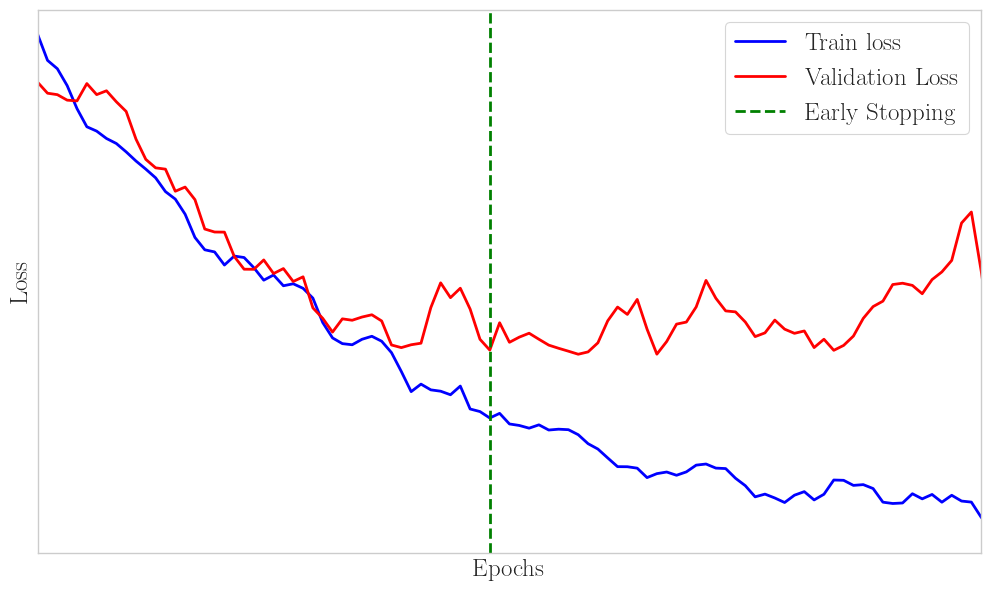

In [78]:
# Función para aplicar un filtro de media móvil
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Simular datos de pérdida de entrenamiento y validación
np.random.seed(0)
epochs = 100
train_loss = np.logspace(0, -1, epochs) + np.random.normal(0, 0.05, epochs)
val_loss = np.logspace(0, -1, epochs) + np.random.normal(0, 0.1, epochs)
val_loss[30:] += np.linspace(0, 0.5, epochs-30)  # Simular sobreajuste después de 30 épocas

# Aplicar suavizado a los datos
train_loss_smooth = smooth(train_loss, 5)
val_loss_smooth = smooth(val_loss, 5)

# Determinar el punto de early stopping
early_stopping_epoch = np.argmin(val_loss_smooth[:50])  # Supongamos que usamos un patience de 50 épocas

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(train_loss_smooth, label=r'$\mathrm{Train\ loss}$', color='blue', linewidth=2)
plt.plot(val_loss_smooth, label=r'$\mathrm{Validation\ Loss}$', color='red', linewidth=2)
plt.axvline(early_stopping_epoch, linestyle='--', color='green', label=r'$\mathrm{Early\ Stopping}$', linewidth=2)
plt.xlabel(r'$\mathrm{Epochs}$', fontsize=18)
plt.ylabel(r'$\mathrm{Loss}$', fontsize=18)
# plt.title('Early Stopping durante el Entrenamiento de una Red Neuronal', fontsize=16)
plt.legend(fontsize=18)
# plt.grid(True)
plt.xlim(2, epochs-2)
plt.xticks([])  # Eliminar valores numéricos del eje x
plt.yticks([])  # Eliminar valores numéricos del eje y
plt.tight_layout()

# Guardar la imagen en alta calidad
plt.savefig("figures/early_stopping.pdf", format="pdf", dpi=300)

# Mostrar el gráfico
plt.show()

## GIF of temmperature evolution

Import model

In [1]:
import os
import sys
from convlstm import *
import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.patches import Rectangle

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from plot_functions import generar_gif_pcb_comparacion

sys.path.append('../scripts')
from PCB_solver_tr import PCB_solver_main, PCB_case_1, PCB_case_2

sys.path.append('../Convolutional_NN')
from Dataset_Class import *

n_train = 100
time_sim = 100
sequence_length = time_sim+1
lr = 0.01
batch_size = 50
hidden_dims = [32]  # Dimensiones ocultas de las capas LSTM
kernel_size = [(3, 3)]
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"

filename = f"PCB_ConvLSTM_nt{n_train}_{time_sim}s_lr{lr}_bs{batch_size}_h{len(hidden_dims)}_k{kernel_string}.pth"
# filename = f"PCB_ConvLSTM_nt{n_train}_{time_sim}s_lr{lr}_bs{batch_size}_h{len(hidden_dims)}_k{kernel_string}_phy_{phy_weight}_bnd{bnd_weight}.pth"

dir_path = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
model_dir = os.path.join(dir_path, 'models', 'ConvLSTM')
model_path = os.path.join(model_dir, filename)

dataset = load_dataset(base_path=dir_path)  # ← carga el dataset base completo (PCB_transient_dataset.pth)

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)

        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13)
model.load_state_dict(torch.load(model_path))
model.eval()

✅ Cargando dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\../Convolutional_NN\Dataset_Class.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)
C:\U

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(35, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [2]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input_tensor = dataset.create_input_from_values(Q_random, T_interfaces_random, T_env_random, sequence_length=sequence_length).to('cpu')

T_true = PCB_case_2(solver='transient', display=False, time=100, dt=1, T_init=298.0, Q_heaters=Q_random, T_interfaces=T_interfaces_random, Tenv=T_env_random)[0]
T_true = T_true.reshape(T_true.shape[0], 13, 13) # reshaping the data grid-shape

pred = model(input_tensor).detach()[0,:,0,:,:]
T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_7612\1188743406.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()


In [4]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook